# Auto encoder

## Read data

In [1]:
from prepare_data import listTurbines


turbines = listTurbines()
turbines

['CRKALN_001',
 'CRKALN_002',
 'CRKALN_003',
 'CRKALN_004',
 'CRKALN_005',
 'CRKALN_006',
 'CRKALN_007',
 'CRKALN_008',
 'CRKALN_009',
 'CRKALN_010']

In [2]:
from prepare_data import TurbineData


turbineData = TurbineData(turbines[1], verbose=True)
print(turbineData.data3d.shape)
print(turbineData.columns)

(297360, 720, 26)
Index(['avgwindspeed', 'avgpower', 'windspeedstandarddeviation',
       'nacelleposition', 'avgwinddirection', 'availablepowerpublished',
       'avgrotorspeed', 'avgpitchangle', 'avgreactivepower',
       'ambienttemperature', 'avghumidity', 'turbinepressure', 'density',
       'latitude', 'longitude', 'cutoutwindspeed', 'ratedwindspeed',
       'rotordiameter', 'hubheight', 'groundlevelaltitude', 'turbulent',
       'underperformanceprobability', 'overperformanceprobability',
       'turbulentvalid', 'underperformanceprobabilityvalid',
       'overperformanceprobabilityvalid'],
      dtype='object')


### Filter valid data

In [3]:
idPower = turbineData.getIdOfColumn("avgpower")
idWind = turbineData.getIdOfColumn("avgwindspeed")

idPower, idWind

(1, 0)

In [4]:
normalIndices = turbineData.getNormalIndices(
    maxConsecutiveInvalid=5,  # 1 hours of consecutive invalid data
    maxInvalidRate=0.5,
    underperformThreshold=1,  # ignore underperf threshold
)

Valid: 10995
Not underperform: 297360
Normal: 10995


## Split train test

In [5]:
import numpy as np


SEED = 17
TEST_RATIO = 0.2


# suffle data
np.random.seed(SEED)
np.random.shuffle(normalIndices)

# split data
n_test = int(len(normalIndices) * TEST_RATIO)
testIndices = normalIndices[:n_test]
trainIndices = normalIndices[n_test:]

print(len(trainIndices), len(testIndices))

8796 2199


In [6]:
# from sklearn.discriminant_analysis import StandardScaler
# from sklearn.impute import KNNImputer
# from sklearn.pipeline import Pipeline

# from cls_dataset import trainTestTurbineDataset


# targetFeats = [
#     "avgwindspeed",
#     "avgpower",
#     "ambienttemperature",
#     "avghumidity",
#     "avgrotorspeed",
# ]
# targetFeatIndices = [turbineData.getIdOfColumn(feat) for feat in targetFeats]

# underPerfValidId = turbineData.getIdOfColumn("underperformanceprobabilityvalid")


# sortedTrainIndices = trainIndices.copy()
# sortedTrainIndices.sort()  # h5py requires sorted indices

# trainData2d = turbineData.data3d[sortedTrainIndices, 0, :]
# # drop invalid
# trainData2d = trainData2d[trainData2d[:, underPerfValidId] == 1]

# transformerTrainData = trainData2d[:, targetFeatIndices]
# print(f"Train data for scaler and imputer {transformerTrainData.shape}")

# stdScaler = StandardScaler()
# stdScaler.fit_transform(transformerTrainData)

# knn = KNNImputer(n_neighbors=3)
# knn.fit_transform(transformerTrainData)

# transformer = Pipeline([("scaler", stdScaler), ("knn", knn)])

# trainSet, testSet = trainTestTurbineDataset(
#     turbineData.data3d,
#     trainIndices,
#     testIndices,
#     targetFeatIndices,
#     transformer.transform,
#     underPerfValidId,
# )

# trainSet.save("tmp/trainSet")
# testSet.save("tmp/testSet")


from cls_dataset import TurbineDataset


trainSet = TurbineDataset.load("tmp/trainSet")
testSet = TurbineDataset.load("tmp/testSet")

with open("./train.log", "w") as f:
    print(trainSet[0][0], file=f)

print(f"Data shape: {trainSet[0][0].shape}")

Data shape: (1, 720, 5)


## Model

In [7]:
import torch
import torch.nn as nn
import torch.nn.functional as F


class Encoder(nn.Module):
    def __init__(self, latentDim):
        super().__init__()
        self.latentDim = latentDim
        # 1 learnable embedding for invalid values
        self.conv1 = nn.Conv2d(1, 8, kernel_size=3, stride=2, padding=1)  # 5->3
        self.conv2 = nn.Conv2d(8, 16, kernel_size=3, stride=2, padding=1)  # 3->2
        self.conv3 = nn.Conv2d(16, 32, kernel_size=2)  # 2->1
        self.flatten = nn.Flatten()
        self.fc1 = nn.Linear(5728, 2048)
        self.fc2 = nn.Linear(2048, latentDim)

        # debug flag
        self.debug = 0  # print once
    def forward(self, x):
        debugging = False
        if self.debug > 0:
            debugging = True
            self.debug -= 1

        x= self.conv1(x)
        x = F.leaky_relu(x)
        if debugging:
            print(f"Conv1: {x.shape}")
            
        x = self.conv2(x)
        x = F.leaky_relu(x)
        if debugging:
            print(f"Conv2: {x.shape}")
            
        x = self.conv3(x)
        x = F.leaky_relu(x)
        if debugging:
            print(f"Conv3: {x.shape}")
            
        x = self.flatten(x)
        x = self.fc1(x)
        x = F.leaky_relu(x)
        x = self.fc2(x)
        return x
class Decoder(nn.Module):
    def __init__(self, latentDim):
        super().__init__()
        self.latentDim = latentDim
        self.fc1 = nn.Linear(latentDim, 2048)
        self.fc2 = nn.Linear(2048, 5728)
        self.conv1 = nn.ConvTranspose2d(32, 16, kernel_size=2)
        self.conv2 = nn.ConvTranspose2d(16, 8, kernel_size=3, stride=2, padding=1)
        self.conv3 = nn.ConvTranspose2d(8, 1, kernel_size=3, stride=2, padding=1)
        self.debug = 0  # print once
    def forward(self, x):
        debugging = False
        if self.debug > 0:
            debugging = True
            self.debug -= 1
        x = self.fc1(x)
        x = F.leaky_relu(x)
        if debugging:
            print(f"FC1: {x.shape}")
        x = self.fc2(x)
        x = F.leaky_relu(x)
        if debugging:
            print(f"FC2: {x.shape}")
        x = x.view(-1, 32, 179, 1)
        x = self.conv1(x)
        x = F.leaky_relu(x)
        if debugging:
            print(f"Conv1: {x.shape}")
        x = self.conv2(x)
        x = F.leaky_relu(x)
        if debugging:
            print(f"Conv2: {x.shape}")
        x = self.conv3(x)
        if debugging:
            print(f"Conv3: {x.shape}")
        return x
class Autoencoder(nn.Module):
    def __init__(self, latent_dim: int):
        super().__init__()
        self.encoder = Encoder(latent_dim)
        self.decoder = Decoder(latent_dim)
    def forward(self, x):
        latent = self.encoder(x)
        reconstructed = self.decoder(latent)
        return reconstructed


# test if the model is working
testModel = Autoencoder(1024)
testModel.encoder.debug = 1

# pass a random tensor to the model
x = torch.randn(32, 1, 720, 5)
output = testModel(x)

print(f"Expected output shape: {x.shape}")
print(f"Output shape: {output.shape}")

# print(x[0])
# print(output[0])

del testModel
del x
del output

Conv1: torch.Size([32, 8, 360, 3])
Conv2: torch.Size([32, 16, 180, 2])
Conv3: torch.Size([32, 32, 179, 1])
Expected output shape: torch.Size([32, 1, 720, 5])
Output shape: torch.Size([32, 1, 717, 5])


## Training 

In [12]:
from matplotlib import pyplot as plt
import torch.optim as optim
from torch.utils.data import DataLoader


device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

trainLoader = DataLoader(trainSet, batch_size=16, shuffle=True, pin_memory=True)
testLoader = DataLoader(testSet, batch_size=16, shuffle=True, pin_memory=True)

model = Autoencoder(516).to(device)
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters())

# Training loop
num_epochs = 20
earlyStopping = 10
losses = []
for epoch in range(num_epochs):
    for x, _ in trainLoader:
        x = x.float().to(device)
        optimizer.zero_grad()

        # Forward pass
        reconstructs = model(x)
        
        # match reconstructed shape with inputs
        n_timestepsReconstructed = reconstructs.shape[-2]
        x = x[:, :, :n_timestepsReconstructed, :]

        # take temp and rotor speed 
        reconstructs = reconstructs[:, :, :, [2,4]]
        x = x[:, :, :, [2,4]]

        loss = criterion(reconstructs, x)

        # Backward pass and optimization
        loss.backward()
        optimizer.step()

        losses.append(loss.item())

    print(f"Epoch [{epoch+1}/{num_epochs}], Loss: {np.mean(losses):.4f}")

# Save the model
torch.save(model.state_dict(), "autoencoder_cnn.pth")


Epoch [1/20], Loss: 4.1646
Epoch [2/20], Loss: 3.1544
Epoch [3/20], Loss: 2.6741
Epoch [4/20], Loss: 2.4274
Epoch [5/20], Loss: 2.2470
Epoch [6/20], Loss: 2.1045
Epoch [7/20], Loss: 2.0126
Epoch [8/20], Loss: 1.9256
Epoch [9/20], Loss: 1.8549
Epoch [10/20], Loss: 1.7935
Epoch [11/20], Loss: 1.7319
Epoch [12/20], Loss: 1.6830
Epoch [13/20], Loss: 1.6326
Epoch [14/20], Loss: 1.5962
Epoch [15/20], Loss: 1.5529
Epoch [16/20], Loss: 1.5124
Epoch [17/20], Loss: 1.4780
Epoch [18/20], Loss: 1.4455
Epoch [19/20], Loss: 1.4121
Epoch [20/20], Loss: 1.3834


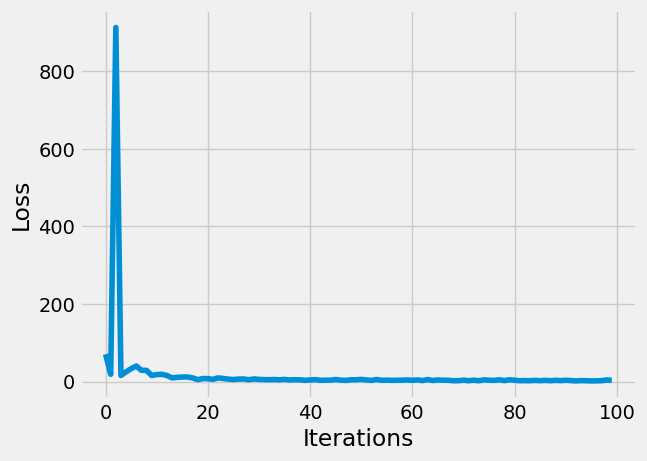

In [9]:
plt.style.use("fivethirtyeight")
plt.xlabel("Iterations")
plt.ylabel("Loss")

# Plotting the last 100 values

plt.plot(losses[:100])

## Evaluating

In [18]:
tempIn = []
tempOut = []

rotIn = []
rotOut = []

model.eval()
with torch.no_grad():
    for x, _ in testLoader:
        x = x.float().to(device)
        reconstructs = model(x)

        n_timestepsReconstructed = reconstructs.shape[-2]
        x = x[:, :, :n_timestepsReconstructed, :]

        for sample in x.detach().cpu().numpy():
            for channel in sample:
                for timestep in channel:
                    tempIn.append(timestep[2])
                    rotIn.append(timestep[4])
                    
        for sample in reconstructs.detach().cpu().numpy():
            for channel in sample:
                for timestep in channel:
                    tempOut.append(timestep[0])
                    rotOut.append(timestep[1])


In [13]:
tempIn, tempOut = zip(*sorted(zip(tempIn, tempOut)))
rotIn, rotOut = zip(*sorted(zip(rotIn, rotOut)))

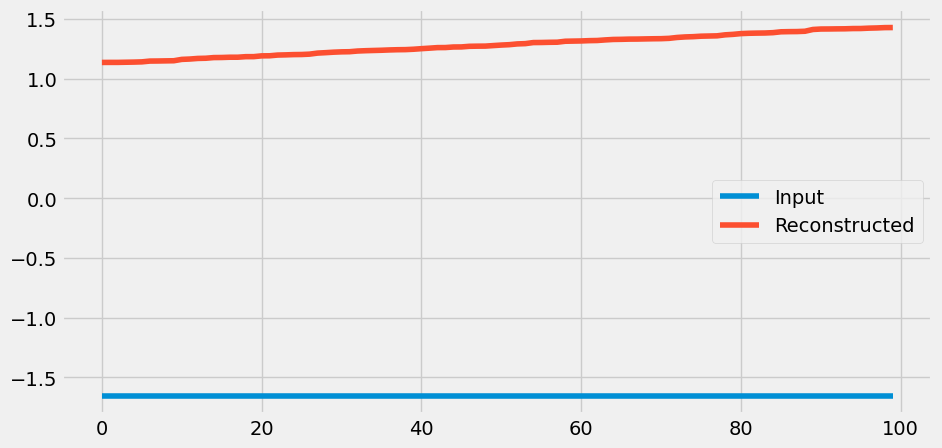

In [17]:
plt.figure(figsize=(10, 5))
plt.plot(rotIn[5000:5100], label="Input")
plt.plot(rotOut[5000:5100], label="Reconstructed")
plt.legend()
plt.show()